In [147]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import label_binarize
#!pip install varClusHi
from varclushi import VarClusHi


pd.set_option('display.max_columns', None)

In [148]:
random_seed = 333 
np.random.seed(random_seed)

# Data

In [149]:
df = pd.read_csv('diabetes.csv')

In [150]:
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

# Feature Engineering

In [151]:
df['Glucose_BMI_Ratio'] = df['Glucose'] / df['BMI']

df['Insulin_Glucose_Ratio'] = df['Insulin'] / df['Glucose']

df['Glucose_Insulin_Product'] = df['Glucose'] * df['Insulin']

df['Age_Pregnancies_Product'] = df['Age'] * df['Pregnancies']

bins = [0, 18.5, 24.9, 29.9, 100]
labels = ['Underweight', 'Normal', 'Overweight', 'Obese']
df['BMI_Category'] = pd.cut(df['BMI'], bins=bins, labels=labels)

In [152]:
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  Glucose_BMI_Ratio  \
0                     0.627   50        1           4.404762   
1                     0.351   31        0           3.195489   
2                     0.672   32        1           7.854077   
3                     0.167   21        0           3.167260   
4                     2.288   33        1           3.178654   

   Insulin_Glucose_Ratio  Glucose_Insulin_Product  Age_Pregnancies_Product  \
0               0.000000                        0                      300   
1               0.000000                        0                       31   
2               0.000000                        0                      256   
3               1.056180                     8366                       21   
4               1.226277                    23016                        0   

  BMI_Category  
0        Obese  
1   Overweight  
2       Normal  
3   Overweight  
4        Obese

In [153]:
encoder = OneHotEncoder(sparse_output=False, drop='first')

encoded_columns = encoder.fit_transform(df[['BMI_Category']])

encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(['BMI_Category']))

df = pd.concat([df.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

df.drop(columns=['BMI_Category'], inplace=True)

In [154]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome',
       'Glucose_BMI_Ratio', 'Insulin_Glucose_Ratio', 'Glucose_Insulin_Product',
       'Age_Pregnancies_Product', 'BMI_Category_Obese',
       'BMI_Category_Overweight', 'BMI_Category_Underweight',
       'BMI_Category_nan'],
      dtype='object')

In [155]:
num_cols = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 
       'Glucose_BMI_Ratio', 'Insulin_Glucose_Ratio', 'Glucose_Insulin_Product',
       'Age_Pregnancies_Product']
cat_cols = ['BMI_Category_Obese', 'BMI_Category_Overweight', 'BMI_Category_Underweight']

# Data Cleaning

## Missings

In [156]:
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
Glucose_BMI_Ratio           0
Insulin_Glucose_Ratio       4
Glucose_Insulin_Product     0
Age_Pregnancies_Product     0
BMI_Category_Obese          0
BMI_Category_Overweight     0
BMI_Category_Underweight    0
BMI_Category_nan            0
dtype: int64

In [157]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [158]:
df.isna().sum()

Pregnancies                  0
Glucose                      0
BloodPressure                0
SkinThickness                0
Insulin                      0
BMI                          0
DiabetesPedigreeFunction     0
Age                          0
Outcome                      0
Glucose_BMI_Ratio           11
Insulin_Glucose_Ratio        5
Glucose_Insulin_Product      0
Age_Pregnancies_Product      0
BMI_Category_Obese           0
BMI_Category_Overweight      0
BMI_Category_Underweight     0
BMI_Category_nan             0
dtype: int64

In [159]:
mean_insulin_glucose_ratio = df['Insulin_Glucose_Ratio'].mean()
df['Insulin_Glucose_Ratio'].mean()

0.6233108026891

In [160]:
df['Insulin_Glucose_Ratio'].fillna(mean_insulin_glucose_ratio, inplace=True)

C:\Users\shumi\AppData\Local\Temp\ipykernel_29340\1293845704.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Insulin_Glucose_Ratio'].fillna(mean_insulin_glucose_ratio, inplace=True)


In [161]:
mean_glucose_ratio = df['Glucose_BMI_Ratio'].mean()
df['Glucose_BMI_Ratio'].mean()

3.853252438440911

In [162]:
df['Glucose_BMI_Ratio'].fillna(mean_glucose_ratio, inplace=True)

C:\Users\shumi\AppData\Local\Temp\ipykernel_29340\578485983.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Glucose_BMI_Ratio'].fillna(mean_glucose_ratio, inplace=True)


In [163]:
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
Glucose_BMI_Ratio           0
Insulin_Glucose_Ratio       0
Glucose_Insulin_Product     0
Age_Pregnancies_Product     0
BMI_Category_Obese          0
BMI_Category_Overweight     0
BMI_Category_Underweight    0
BMI_Category_nan            0
dtype: int64

## Outliers

In [164]:
df.describe(percentiles=[0.01, 0.02, 0.05, 0.50, 0.95, 0.98, 0.99])

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
1%        0.000000   57.000000       0.000000       0.000000    0.000000   
2%        0.000000   69.020000       0.000000       0.000000    0.000000   
5%        0.000000   79.000000      38.700000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
95%      10.000000  181.000000      90.000000      44.000000  293.000000   
98%      12.000000  192.320000      99.320000      48.000000  470.940000   
99%      13.000000  196.000000     106.000000      51.330000  519.900000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  \
count  768.000000                768.000000  768.000000  768.000000   
mean    31.992578                  0.471876   33.240885    0.348958   
std      7.884160                  0.331329   11.760232    0.476951   
min      0.000000                  0.078000   21.000000    0.000000   
1%       0.000000                  0.094680   21.000000    0.000000   
2%      19.168000                  0.119020   21.000000    0.000000   
5%      21.800000                  0.140350   21.000000    0.000000   
50%     32.000000                  0.372500   29.000000    0.000000   
95%     44.395000                  1.132850   58.000000    1.000000   
98%     47.526000                  1.390660   64.660000    1.000000   
99%     50.759000                  1.698330   67.000000    1.000000   
max     67.100000                  2.420000   81.000000    1.000000   

       Glucose_BMI_Ratio  Insulin_Glucose_Ratio  Glucose_Insulin_Product  \
count         768.000000             768.000000               768.000000   
mean            3.853252               0.623311             10866.666667   
std             1.139980               0.793442             18378.075446   
min             0.000000               0.000000                 0.000000   
1%              1.736706               0.000000                 0.000000   
2%              1.952270               0.000000                 0.000000   
5%              2.245431               0.000000                 0.000000   
50%             3.768473               0.398198              2718.000000   
95%             5.763274               2.130311             45724.250000   
98%             6.440414               2.803736             72988.140000   
99%             7.211742               3.370900             84518.230000   
max             8.255319               4.838710            159894.000000   

       Age_Pregnancies_Product  BMI_Category_Obese  BMI_Category_Overweight  \
count               768.000000          768.000000               768.000000   
mean                149.355469            0.614583                 0.233073   
std                 160.892726            0.487011                 0.423064   
min                   0.000000            0.000000                 0.000000   
1%                    0.000000            0.000000                 0.000000   
2%                    0.000000            0.000000                 0.000000   
5%                    0.000000            0.000000                 0.000000   
50%                  83.000000            1.000000                 0.000000   
95%                 489.900000            1.000000                 1.000000   
98%                 561.000000            1.000000                 1.000000   
99%                 634.620000            1.000000                 1.000000   
max                 799.000000            1.000000                 1.000000   

       BMI_Category_Underweight  BMI_Category_nan  
count                768.

# EDA

In [165]:
df.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
Glucose_BMI_Ratio           float64
Insulin_Glucose_Ratio       float64
Glucose_Insulin_Product       int64
Age_Pregnancies_Product       int64
BMI_Category_Obese          float64
BMI_Category_Overweight     float64
BMI_Category_Underweight    float64
BMI_Category_nan            float64
dtype: object

In [166]:
df['Outcome'] = df['Outcome'].astype('object')

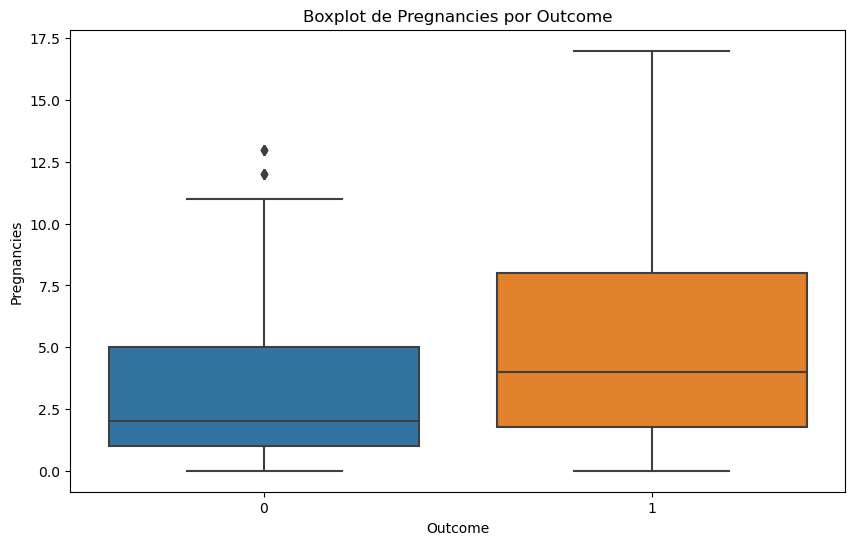

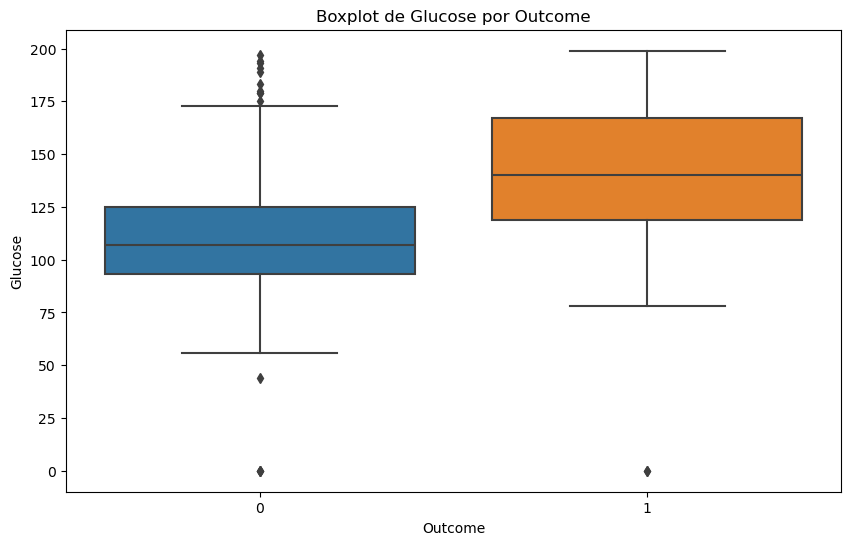

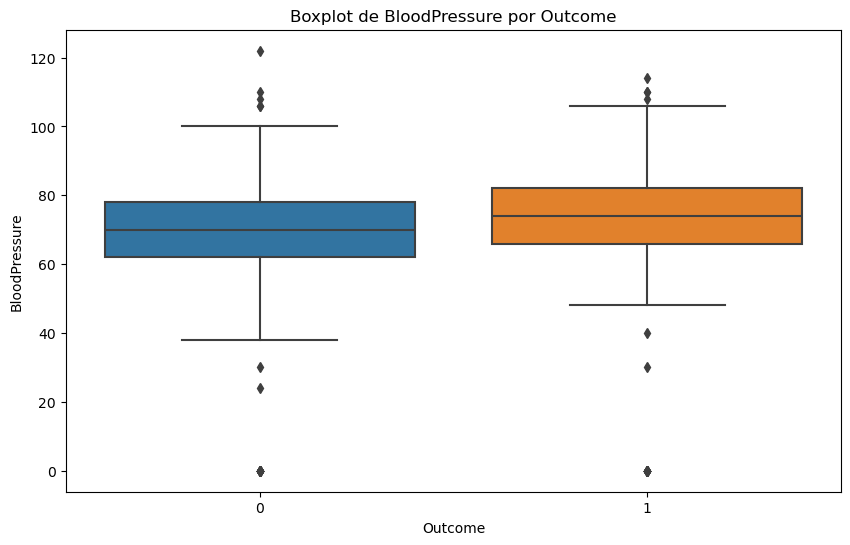

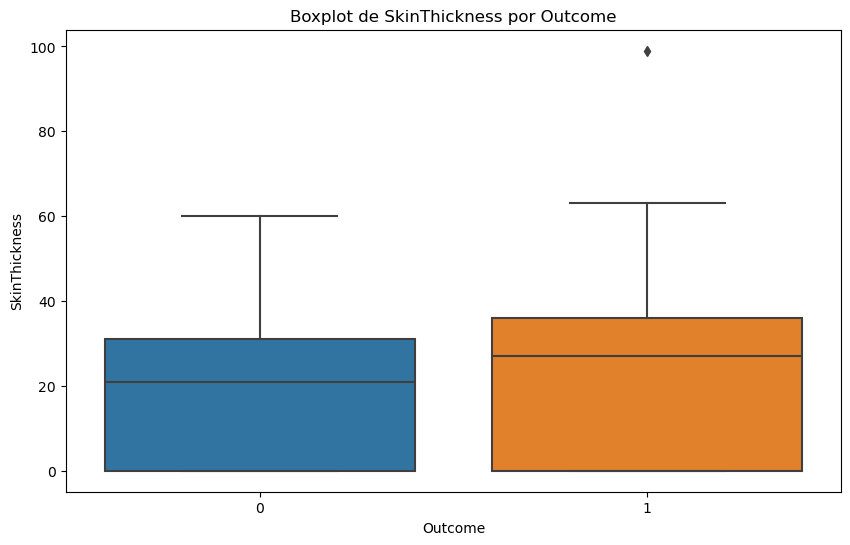

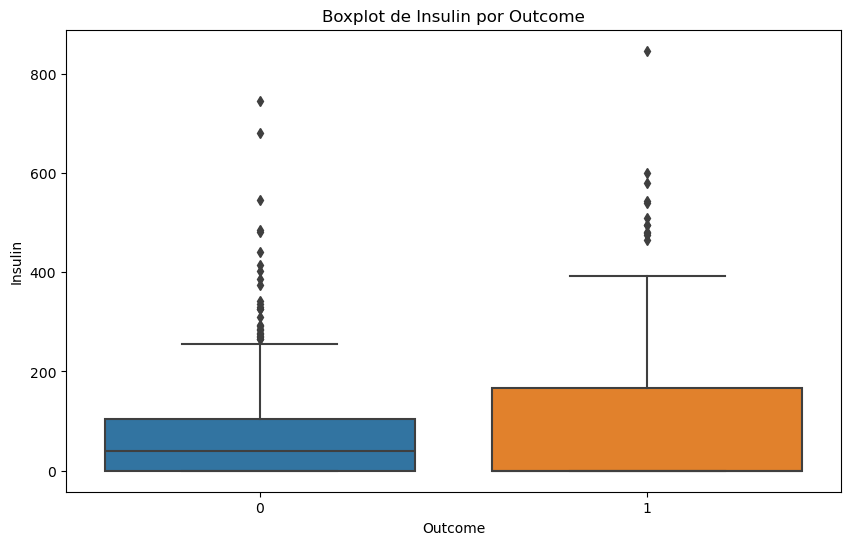

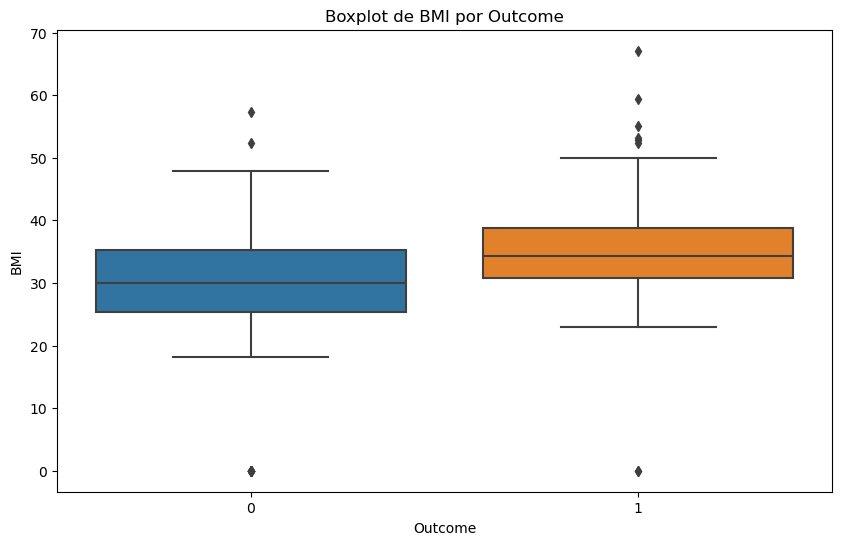

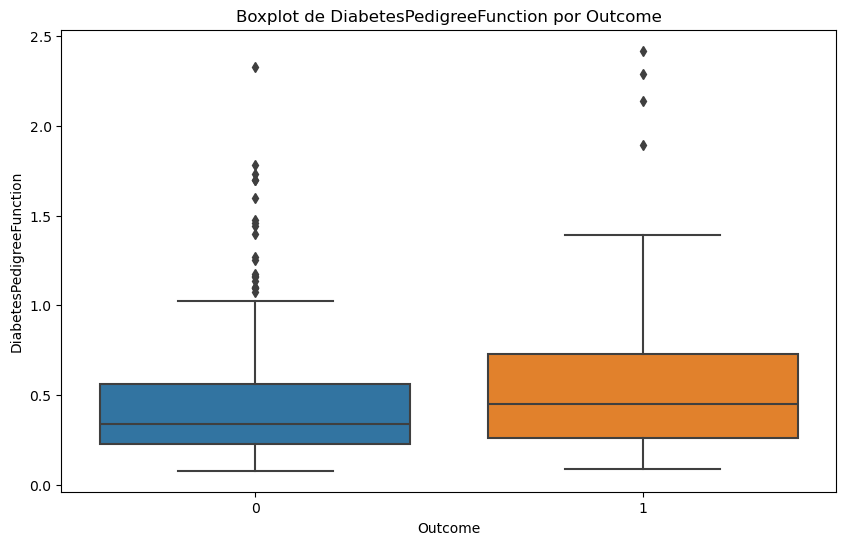

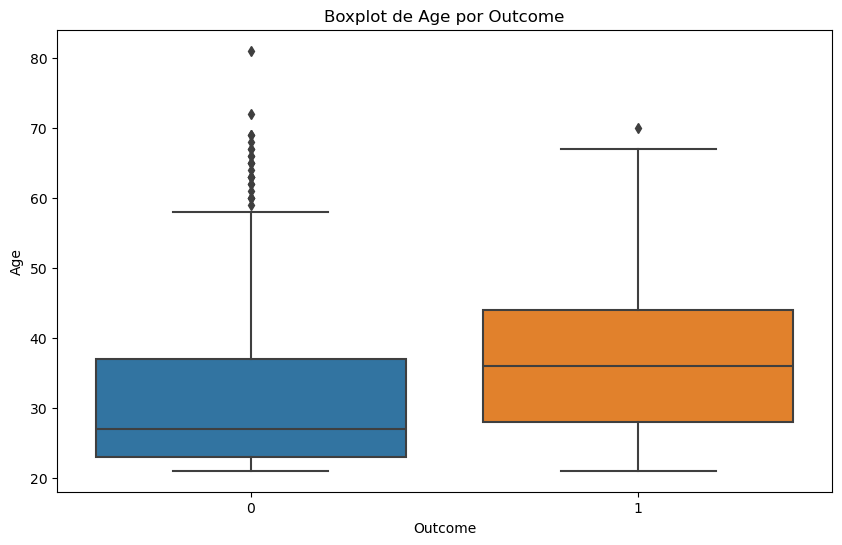

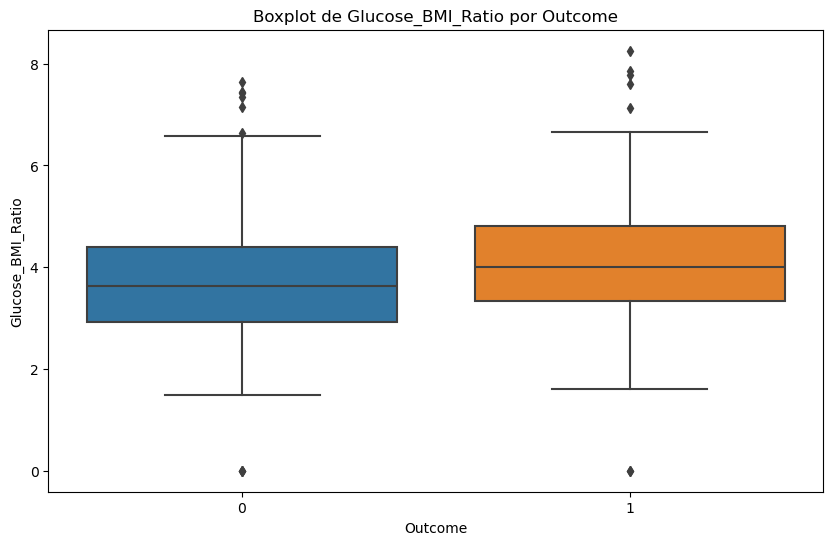

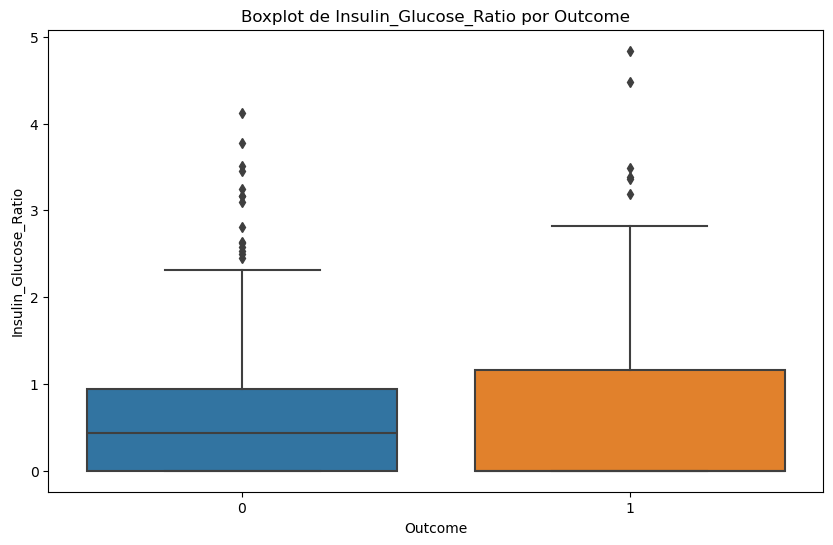

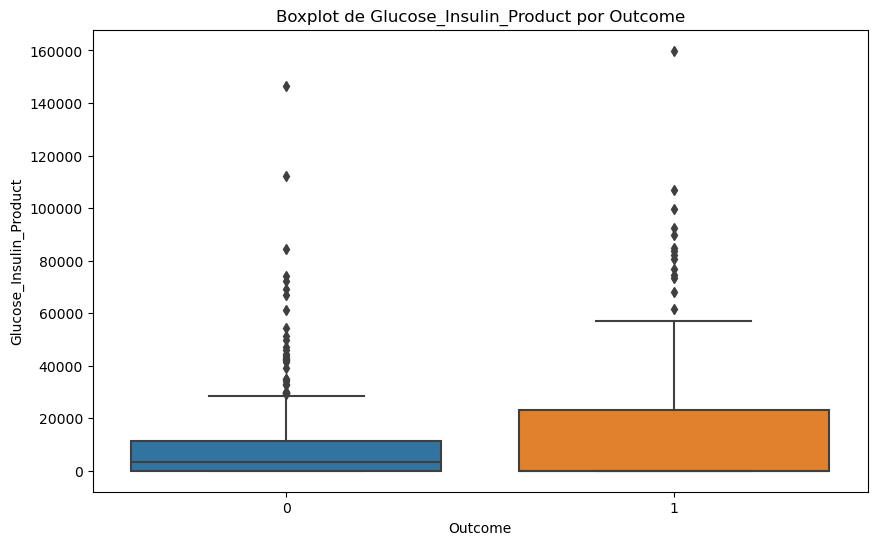

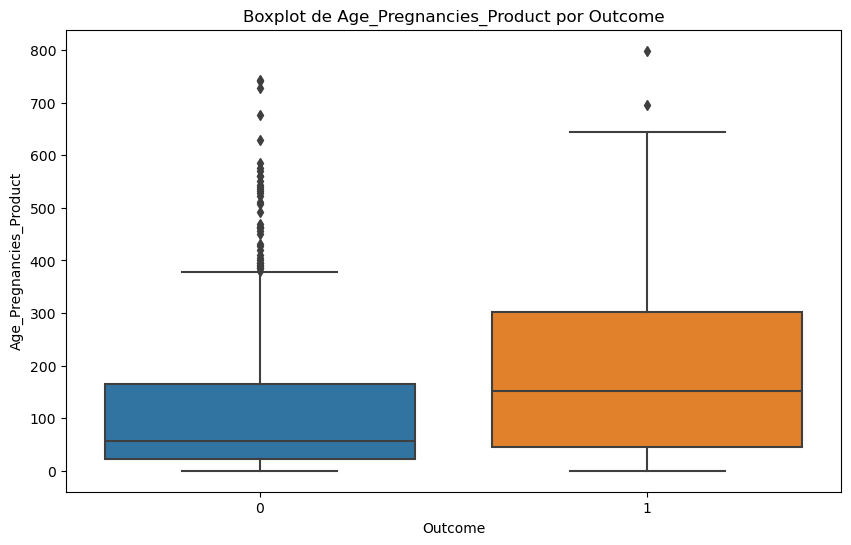

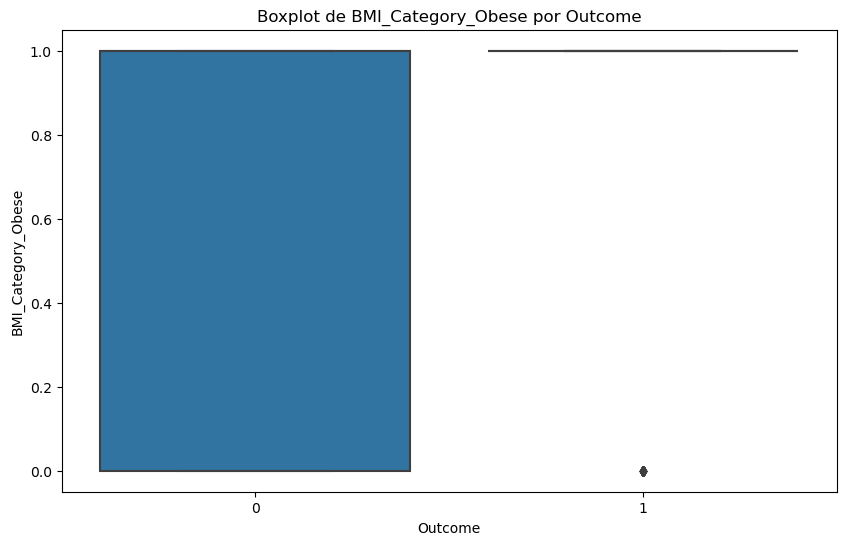

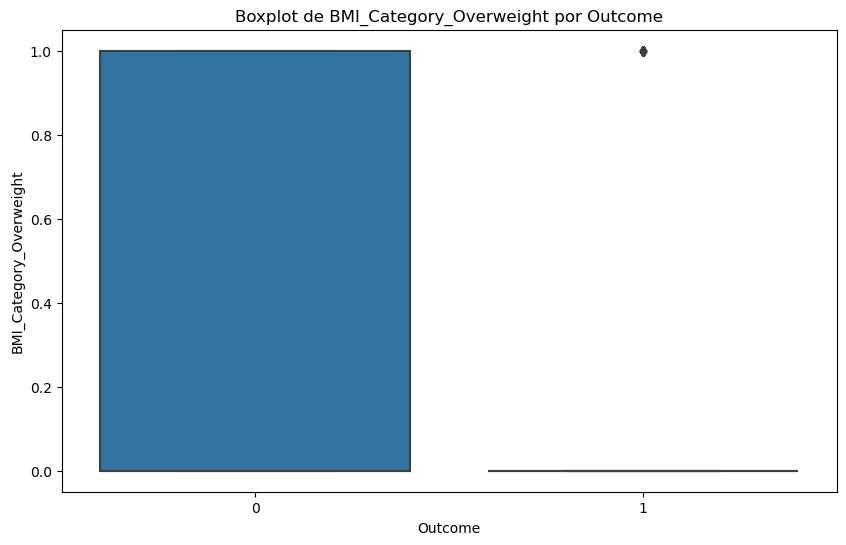

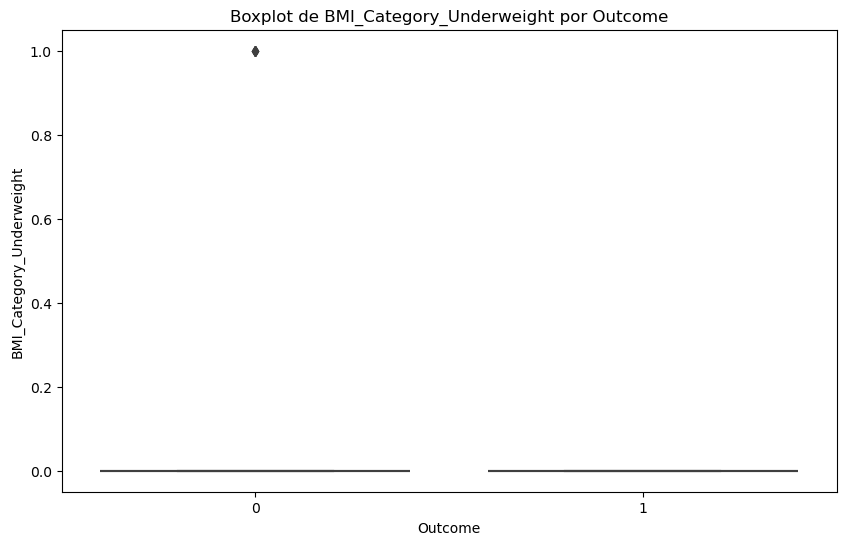

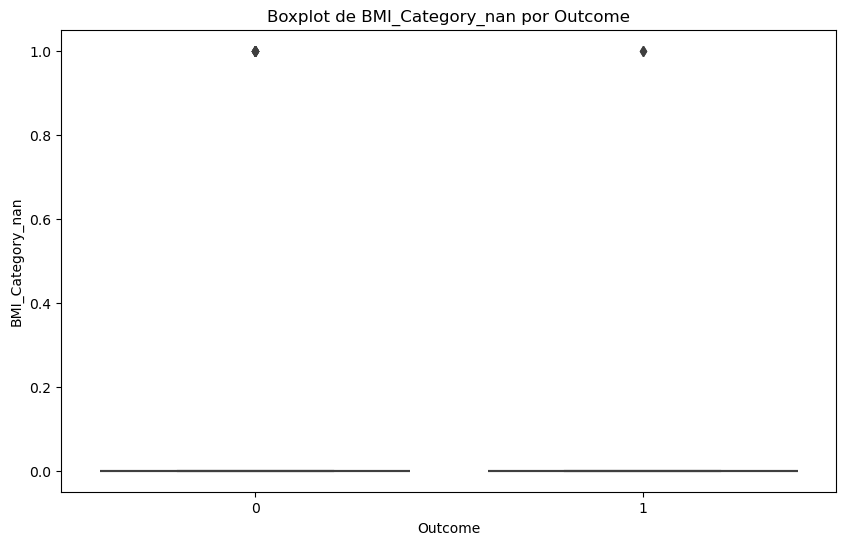

In [167]:
for column in df.select_dtypes(include=['int64', 'float64']).columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Outcome', y=column, data=df)
    plt.title(f'Boxplot de {column} por Outcome')
    plt.show()

C:\Users\shumi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\shumi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\shumi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\shumi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a len

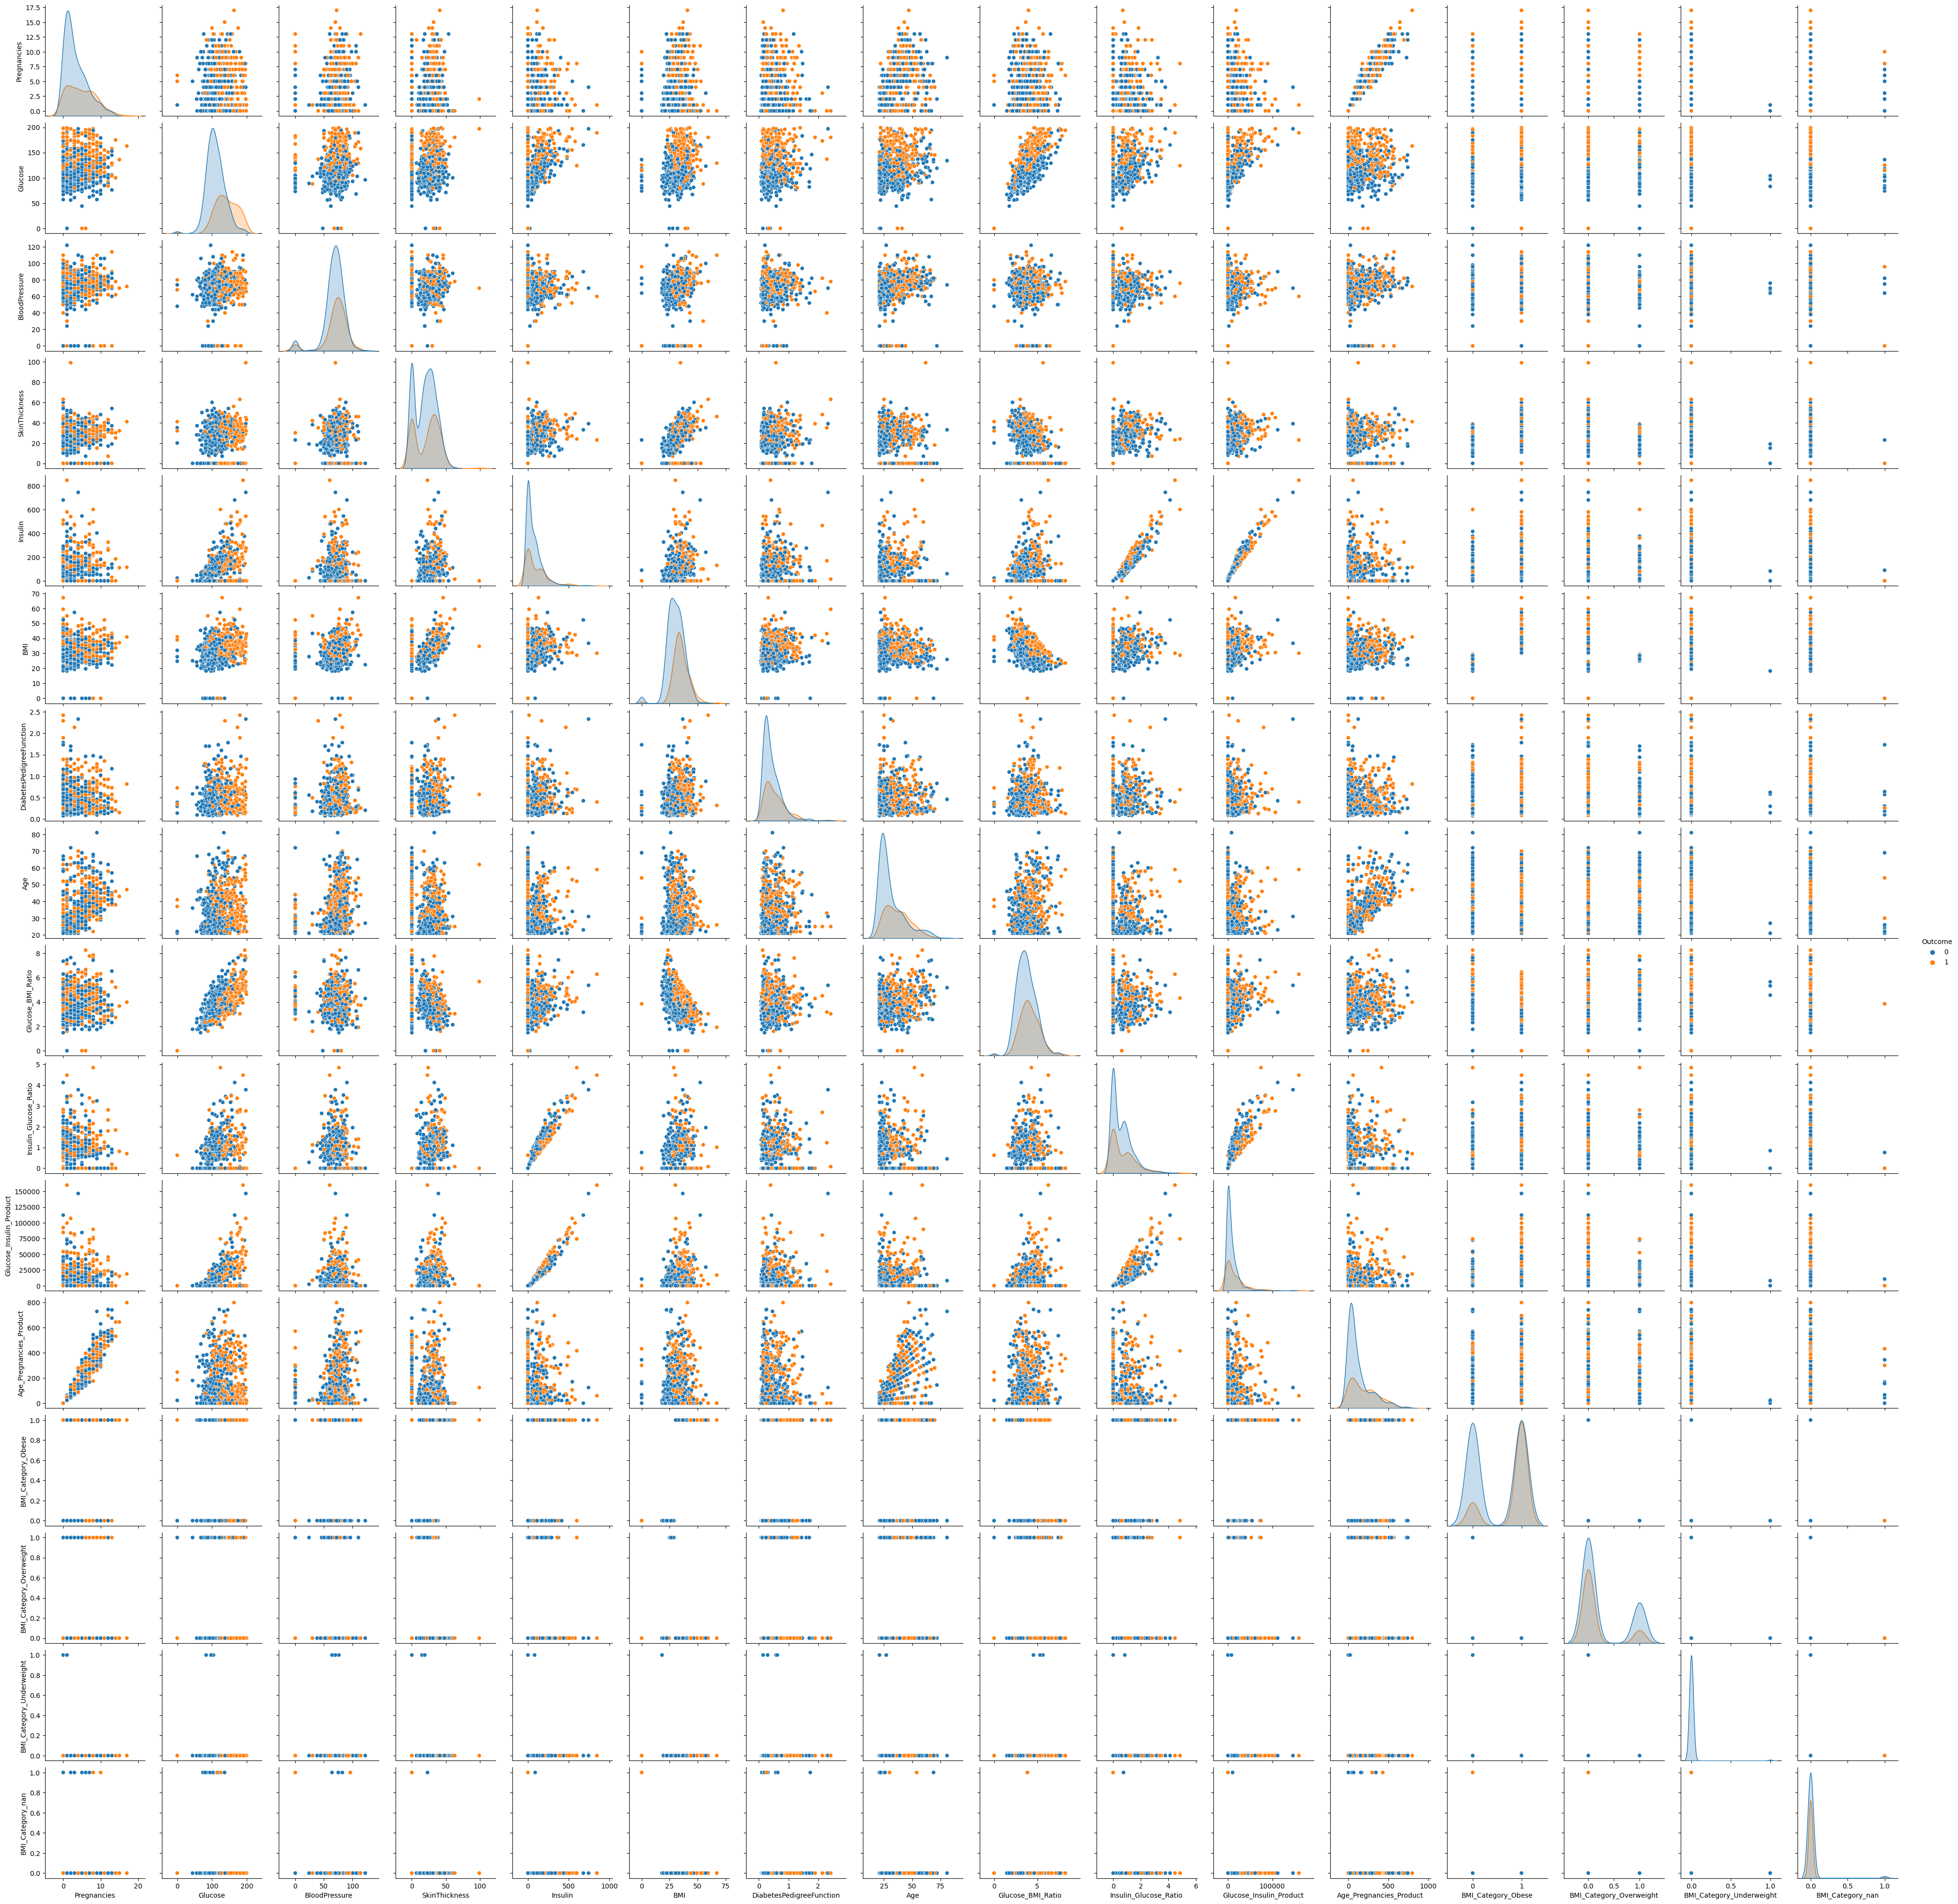

In [168]:
sns.pairplot(df, hue='Outcome', diag_kind='kde')
plt.show()


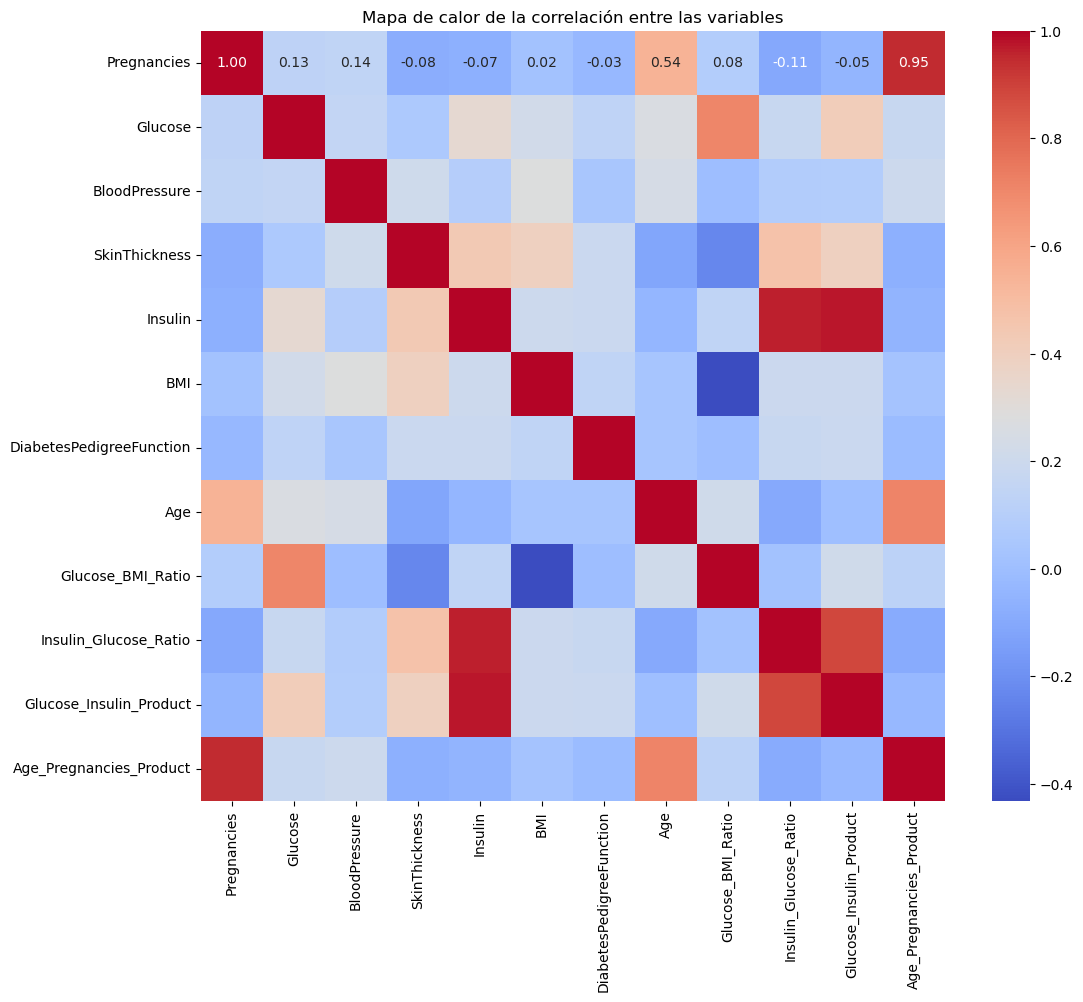

In [169]:
plt.figure(figsize=(12, 10))
corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Mapa de calor de la correlación entre las variables')
plt.show()

In [170]:
vc = VarClusHi(df= df[num_cols] , feat_list=num_cols)

In [171]:
vc.varclus()

In [172]:
rs = vc.rsquare
rs = rs.sort_values( by = ['Cluster','RS_Ratio'] ,ascending=[1,1] ).reset_index(drop=True)
rs['id'] = rs.groupby('Cluster').cumcount() + 1
rs

Cluster                  Variable    RS_Own     RS_NC  RS_Ratio  id
0         0                   Insulin  0.998985  0.158530  0.001207   1
1         0   Glucose_Insulin_Product  0.945675  0.137395  0.062978   2
2         0     Insulin_Glucose_Ratio  0.936690  0.167574  0.076055   3
3         1   Age_Pregnancies_Product  0.947689  0.026287  0.053724   1
4         1               Pregnancies  0.829484  0.013406  0.172833   2
5         1                       Age  0.667986  0.066719  0.355749   3
6         1             BloodPressure  0.109615  0.072928  0.960427   4
7         2                   Glucose  0.854451  0.098926  0.161529   1
8         2         Glucose_BMI_Ratio  0.854451  0.120210  0.165436   2
9         3                       BMI  0.598179  0.038995  0.418126   1
10        3             SkinThickness  0.637328  0.194810  0.450418   2
11        3  DiabetesPedigreeFunction  0.262962  0.034590  0.763446   3

In [173]:
num_cols = rs.loc[ rs['id'] == 1 ]['Variable'].tolist()

In [174]:
num_cols

['Insulin', 'Age_Pregnancies_Product', 'Glucose', 'BMI']

array([[<Axes: title={'center': 'Insulin'}>,
        <Axes: title={'center': 'Age_Pregnancies_Product'}>],
       [<Axes: title={'center': 'Glucose'}>,
        <Axes: title={'center': 'BMI'}>]], dtype=object)

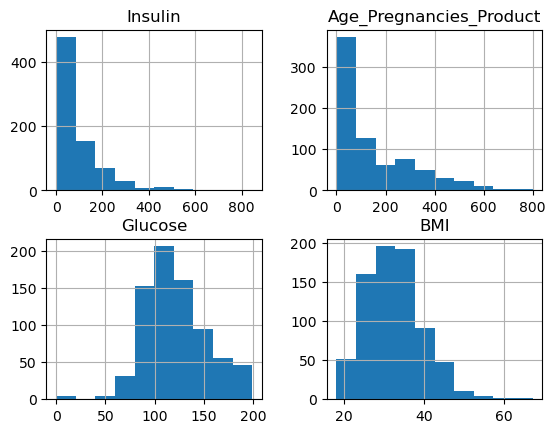

In [175]:
X[num_cols].hist()

# Model

In [176]:
X = df[num_cols + cat_cols]
y = df['Outcome']
y=y.astype('int')

In [177]:
X

Insulin  Age_Pregnancies_Product  Glucose   BMI  BMI_Category_Obese  \
0          0                      300      148  33.6                 1.0   
1          0                       31       85  26.6                 0.0   
2          0                      256      183  23.3                 0.0   
3         94                       21       89  28.1                 0.0   
4        168                        0      137  43.1                 1.0   
..       ...                      ...      ...   ...                 ...   
763      180                      630      101  32.9                 1.0   
764        0                       54      122  36.8                 1.0   
765      112                      150      121  26.2                 0.0   
766        0                       47      126  30.1                 1.0   
767        0                       23       93  30.4                 1.0   

     BMI_Category_Overweight  BMI_Category_Underweight  
0                        0.0                       0.0  
1                        1.0                       0.0  
2                        0.0                       0.0  
3                        1.0                       0.0  
4                        0.0                       0.0  
..                       ...                       ...  
763                      0.0                       0.0  
764                      0.0                       0.0  
765                      1.0                       0.0  
766                      0.0                       0.0  
767                      0.0                       0.0  

[768 rows x 7 columns]

In [178]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [179]:
scaler = MinMaxScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [180]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [181]:
y_pred = model.predict(X_test)

In [182]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

Confusion Matrix:
[[86 13]
 [23 32]]

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.87      0.83        99
           1       0.71      0.58      0.64        55

    accuracy                           0.77       154
   macro avg       0.75      0.73      0.73       154
weighted avg       0.76      0.77      0.76       154


Accuracy Score:
0.7662337662337663


In [183]:
param_grid = {
    'C': np.arange(0, 100, 0.1),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits
Best Parameters: {'C': 1.7000000000000002, 'penalty': 'l2', 'solver': 'liblinear'}


C:\Users\shumi\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
10 fits failed out of a total of 10000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\shumi\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\shumi\anaconda3\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\shumi\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\shumi\anaconda3\Lib\site-packag

Confusion Matrix:
[[86 13]
 [21 34]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.87      0.83        99
           1       0.72      0.62      0.67        55

    accuracy                           0.78       154
   macro avg       0.76      0.74      0.75       154
weighted avg       0.78      0.78      0.77       154


Accuracy Score:
0.7792207792207793


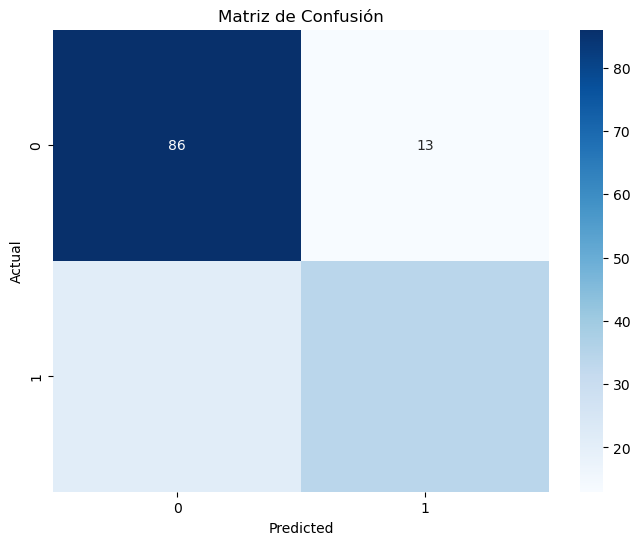

In [184]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.show()
